In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)


In [7]:
# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [8]:
# Using the inspector to print the column names within the 'Measurement' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
# Using the inspector to print the column names within the 'Station' table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [11]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [12]:
# Save references to each table
Mmt = Base.classes.measurement
Sta = Base.classes.station

In [13]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
results = session.query(Mmt.date).order_by(Mmt.date.desc()).first()
results

('2017-08-23')

In [15]:
# Perform a query to retrieve the data and precipitation scores
mmt_past_year = session.query(Mmt.date, Mmt.prcp).filter(Mmt.date >= '2016-08-23').order_by(Mmt.date).all()

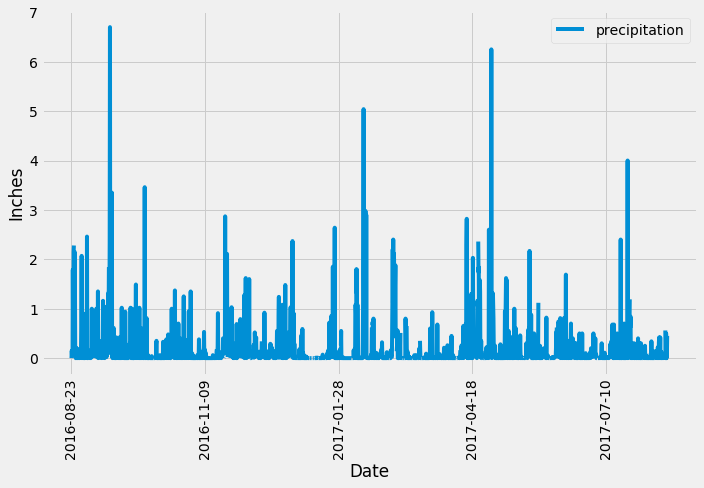

In [16]:
# Save the query results as a Pandas DataFrame and set the index to the date column
mmt_df = pd.DataFrame(mmt_past_year, columns=['Date','precipitation'])
mmt_df.set_index('Date', inplace=True)

# Sort the dataframe by date
mmt_df.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
mmt_df.plot(kind='line', rot=90, figsize=(10,7), legend=True)
    #xaxis.set_major_locator(plt.MaxNLocator(9))
plt.ylabel('Inches')
plt.tight_layout()
plt.savefig('Images/Precipitation_last_year.png')
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
mmt_df['precipitation'].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

In [18]:
# Design a query to show how many stations are available in this dataset?
session.query(Mmt.station).distinct().count()

9

In [24]:
session.query(Sta.id).count()

9

In [36]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sta_counts = session.query(Mmt.station.distinct(),
                            func.count(Mmt.station).label('total')).\
                            group_by(Mmt.station).order_by(desc('total'))

for row in sta_counts:
    print(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
act_sta_temp = session.query(Mmt.station, Mmt.tobs).filter(Mmt.station=='USC00519281')
act_sta_df = pd.DataFrame(act_sta_temp, columns=['Station','tobs'])
act_sta_df['tobs'].describe()

count    2772.000000
mean       71.663781
std         4.357642
min        54.000000
25%        69.000000
50%        72.000000
75%        74.000000
max        85.000000
Name: tobs, dtype: float64

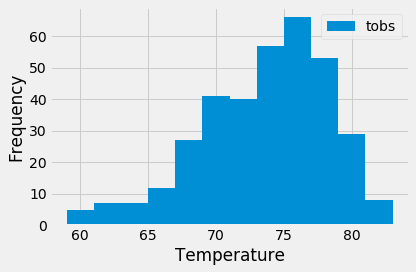

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
double_filt = session.query(Mmt.date, Mmt.station, Mmt.tobs).\
                filter(Mmt.station=='USC00519281').\
                filter(Mmt.date >= '2016-08-23').\
                order_by(Mmt.date).all()
double_filt_df = pd.DataFrame(double_filt, columns=['Date','Station','tobs'])
double_filt_df.plot(kind='hist', legend=True, bins=12)
plt.xlabel('Temperature')
plt.tight_layout()
plt.savefig('Images/Temperature_hist_most_active_sta.png')
plt.show()

In [33]:
test = double_filt_df['tobs'].tolist()
test

[77.0,
 77.0,
 80.0,
 80.0,
 75.0,
 73.0,
 78.0,
 77.0,
 78.0,
 80.0,
 80.0,
 78.0,
 78.0,
 78.0,
 73.0,
 74.0,
 80.0,
 79.0,
 77.0,
 80.0,
 76.0,
 79.0,
 75.0,
 79.0,
 78.0,
 79.0,
 78.0,
 78.0,
 76.0,
 74.0,
 77.0,
 78.0,
 79.0,
 79.0,
 77.0,
 80.0,
 78.0,
 78.0,
 78.0,
 77.0,
 79.0,
 79.0,
 79.0,
 79.0,
 75.0,
 76.0,
 73.0,
 72.0,
 71.0,
 77.0,
 79.0,
 78.0,
 79.0,
 77.0,
 79.0,
 77.0,
 78.0,
 78.0,
 78.0,
 78.0,
 77.0,
 74.0,
 75.0,
 76.0,
 73.0,
 76.0,
 74.0,
 77.0,
 76.0,
 76.0,
 74.0,
 75.0,
 75.0,
 75.0,
 75.0,
 71.0,
 63.0,
 70.0,
 68.0,
 67.0,
 77.0,
 74.0,
 77.0,
 76.0,
 76.0,
 75.0,
 76.0,
 75.0,
 73.0,
 75.0,
 73.0,
 75.0,
 74.0,
 75.0,
 74.0,
 75.0,
 73.0,
 75.0,
 73.0,
 73.0,
 74.0,
 70.0,
 72.0,
 70.0,
 67.0,
 67.0,
 69.0,
 70.0,
 68.0,
 69.0,
 69.0,
 66.0,
 65.0,
 68.0,
 62.0,
 75.0,
 70.0,
 69.0,
 76.0,
 76.0,
 74.0,
 73.0,
 71.0,
 74.0,
 74.0,
 72.0,
 71.0,
 72.0,
 74.0,
 69.0,
 67.0,
 72.0,
 70.0,
 64.0,
 63.0,
 63.0,
 62.0,
 70.0,
 70.0,
 62.0,
 62.0,
 63.0,
 65.0,

## Bonus Challenge Assignment

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

NameError: name 'Measurement' is not defined

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
